In [1]:
from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate
from fastai import *
import cv2 as cv
import numpy as np
import pandas as pd
import scipy.io as sio
from scipy.io import loadmat
import pandas as pd


In [2]:
url = "http://imagenet.stanford.edu/internal/car196/"
url_label = "https://ai.stanford.edu/~jkrause/cars"


path = Path('fastai/data/cars_train');
path_label = Path('fastai/data/car_devkit');

tfms = get_transforms()

In [4]:
# Training Data Cleaning code snippet found from source: https://github.com/jianshen92/stanford-car-grab-challenge
mat_data = loadmat(path_label/'cars_train_annos.mat')
mat_meta = loadmat(path_label/'cars_meta.mat')

class_id_label = mat_data['annotations']["class"].squeeze()
fname = mat_data['annotations']["fname"].squeeze()
class_names = mat_meta['class_names'].squeeze()

class_id_label_list = [class_id[0][0] for class_id in class_id_label]
fname_list = [f[0] for f in fname]
class_names_list = [c[0] for c in class_names]

# Mapping id to classnames for verboseness
class_name_label_list = [class_names_list[idx-1] for idx in class_id_label_list] 

train_df = pd.DataFrame(
    {'fname': fname_list,
     'label': class_name_label_list,
    })


In [5]:
# Just to check if the data has been loaded correctly
train_df.head()

,fname,label
0,00001.jpg,Audi TTS Coupe 2012
1,00002.jpg,Acura TL Sedan 2012
2,00003.jpg,Dodge Dakota Club Cab 2007
3,00004.jpg,Hyundai Sonata Hybrid Sedan 2012
4,00005.jpg,Ford F-450 Super Duty Crew Cab 2012


In [6]:
tfms = get_transforms()

In [7]:
# generally in all machine learning tasks, we have to make all of out data about the same size.
# this method does exactly that by transforming the data. does the center cropping, resizing and padding.
# there is also some randomizaiton which actually helps in data augmentation
data = (
    ImageList
    .from_df(df=train_df, path=path)
    .split_by_rand_pct(valid_pct=0.2, seed=1010) # Seed to make sure validation set is the same everytime we repeat an experiment
    .label_from_df(cols="label")
    .transform(tfms=tfms, size=299, resize_method=ResizeMethod.SQUISH, padding_mode='reflection')
    .databunch(bs=16)
    .normalize(imagenet_stats) # Normalize Image according to ImageNet's Normalization because we are using ImageNet's pretrained model
)

/Users/mayank/anaconda3/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2693: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "
/Users/mayank/anaconda3/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2693: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "
/Users/mayank/anaconda3/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2693: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "
/Users/may

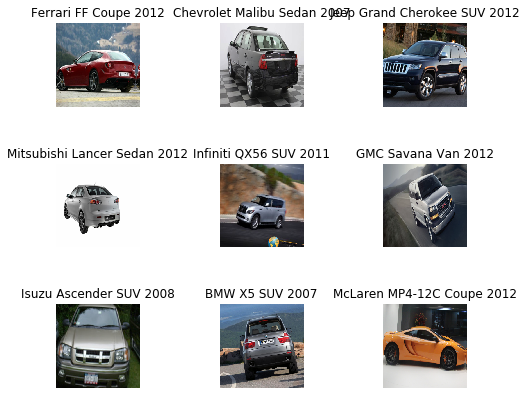

In [9]:
import warnings;
warnings.simplefilter('ignore')
# Taking a look at the dataset.
data.show_batch(rows = 3, figsize= (7,6))

## test data donwload 

In [11]:
test_path = untar_data('http://imagenet.stanford.edu/internal/car196/cars_test')
test_mat_path = download_data(url='http://imagenet.stanford.edu/internal/car196/cars_test_annos_withlabels', ext=".mat")

In [12]:
## test Data Cleaning code snippet found from source: https://github.com/jianshen92/stanford-car-grab-challenge

mat_test = loadmat(path_label/'cars_test_annos.mat')
mat_test_label = loadmat(test_mat_path)

test_id_label = mat_test_label['annotations']["class"].squeeze()
test_fname = mat_test_label['annotations']["fname"].squeeze()

test_id_label_list = [class_id[0][0] for class_id in test_id_label]
test_fname_list = [f[0] for f in test_fname] 
class_names_list;

# Mapping id to classnames for verboseness
test_class_name_label_list = [class_names_list[idx-1] for idx in test_id_label_list] 

test_df = pd.DataFrame(
    {'fname': test_fname_list,
     'label': test_class_name_label_list,
    })

In [13]:
test_df.head()

,fname,label
0,00001.jpg,Suzuki Aerio Sedan 2007
1,00002.jpg,Ferrari 458 Italia Convertible 2012
2,00003.jpg,Jeep Patriot SUV 2012
3,00004.jpg,Toyota Camry Sedan 2012
4,00005.jpg,Tesla Model S Sedan 2012


In [14]:
df1 = train_df
df1["is_valid"] = False
df2 = test_df
df2["is_valid"] = True
real_test_df = pd.concat([df1,df2])

In [15]:
real_test_df.head()

,fname,label,is_valid
0,00001.jpg,Audi TTS Coupe 2012,False
1,00002.jpg,Acura TL Sedan 2012,False
2,00003.jpg,Dodge Dakota Club Cab 2007,False
3,00004.jpg,Hyundai Sonata Hybrid Sedan 2012,False
4,00005.jpg,Ford F-450 Super Duty Crew Cab 2012,False


In [16]:
# Creating the test data batch for testing the Network later

test_data = (
    ImageList
    .from_df(df=real_test_df, path=test_path)
    .split_from_df()
    .label_from_df(cols="label")
    .transform(tfms=tfms, size=299, resize_method=ResizeMethod.SQUISH, padding_mode='reflection')
    .databunch(bs=16)
    .normalize(imagenet_stats)
)

In [17]:

# learner is a general concept in fastai. 
# It creates a Convolutional Neural Network.
# @params
# data: databunch object that contains the data non which the model needs to train
# second parameter is the architecture. The resnet is an architecture that works very well nearly all the time. 

learn = cnn_learner(data, models.resnet152, metrics=[accuracy]).mixup()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


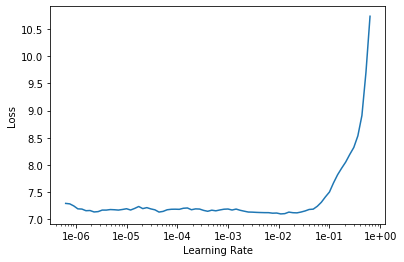

In [18]:
learn.lr_find()
learn.recorder.plot()

In [19]:
learn.save('s1-res152-mixup-b16')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


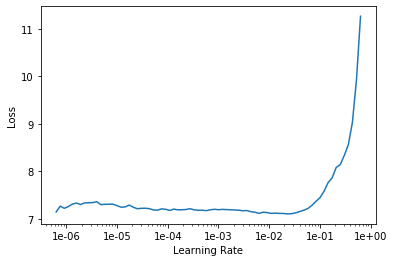

In [20]:
learn.lr_find()
learn.recorder.plot()

In [21]:
learn.unfreeze()

## Training repeatedly to train the model and update the weights

In [ ]:
learn.fit_one_cycle(5, max_lr=slice(1e-5, 1e-3))

epoch,train_loss,valid_loss,accuracy,time


In [ ]:
learn.save('version-2-res152')

In [ ]:
learn.validate(test_data.valid_dl)

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(5, max_lr=slice(1e-6, 1e-4))

In [ ]:
learn.save('version-3-res152')

In [ ]:
learn.validate(test_data.valid_dl)

In [ ]:
learn.fit_one_cycle(5, max_lr=slice(1e-6, 1e-4))

In [ ]:
learn.save('version-4-res152')

In [ ]:
learn.fit_one_cycle(5, max_lr=slice(1e-5, 1e-4))

In [ ]:
learn.fit_one_cycle(5, max_lr=slice(1e-6, 1e-4), wd=0.005)

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.save('version-5-res152')


In [ ]:
learn = cnn_learner(data, models.resnet152, metrics=[accuracy]).load('version-5-res152')

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(5, max_lr=slice(1e-6, 1e-4))

In [ ]:
learn.save('s5-res152-mixup-b16-v90.9-t91.47')

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(5, max_lr=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy,time


In [ ]:
learn.validate(test_data.valid_dl)